<a href="https://colab.research.google.com/github/Vonewman/Practical_Deep_learning/blob/master/01_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate

In [4]:
bs = 64

## Looking at the data

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

In [5]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False, verbose=False) -> pathlib.Path
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`.



In [6]:
path = untar_data(URLs.PETS); path

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [7]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images')]

In [8]:
path_anno = path / 'annotations'
path_img = path / 'images'

In [9]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/saint_bernard_97.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Persian_260.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/pug_69.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/english_setter_17.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Birman_16.jpg')]

In [10]:
np.random.seed(2)
pat = re.compile('/([^/]+)_\d+.jpg$')

In [11]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  )
data = data.normalize(imagenet_stats)

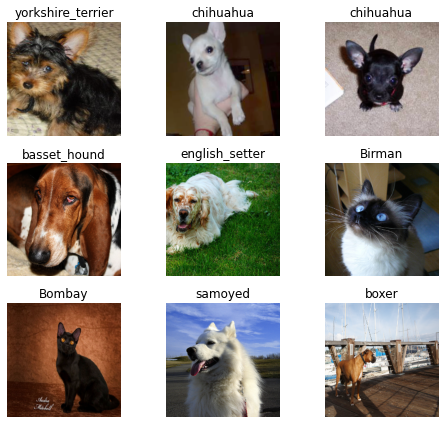

In [12]:
data.show_batch(rows=3, figsize=(7,6))

In [13]:
print(data.classes)
len(data.classes),data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [14]:
learn = cnn_learner(data, models.resnet34, pretrained=True, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


Now, we can train it! We will train it for four cycles through all our data

In [15]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.421644,0.300732,0.103518,01:27
1,0.613418,0.243219,0.082544,01:27
2,0.390269,0.180730,0.056157,01:27
3,0.295357,0.180877,0.058187,01:26


In [16]:
learn.save('stage_1')

## Let's look at our results

With the model trained, let's look at where our model might've messed up. What species did it have trouble differentiating between? So long as the misidentifications are not too crazy, our model is actually working.

Then we will plot our confusion matrix, see what specific species it cannot seem to differentiate between

In [17]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idx = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idx)

True

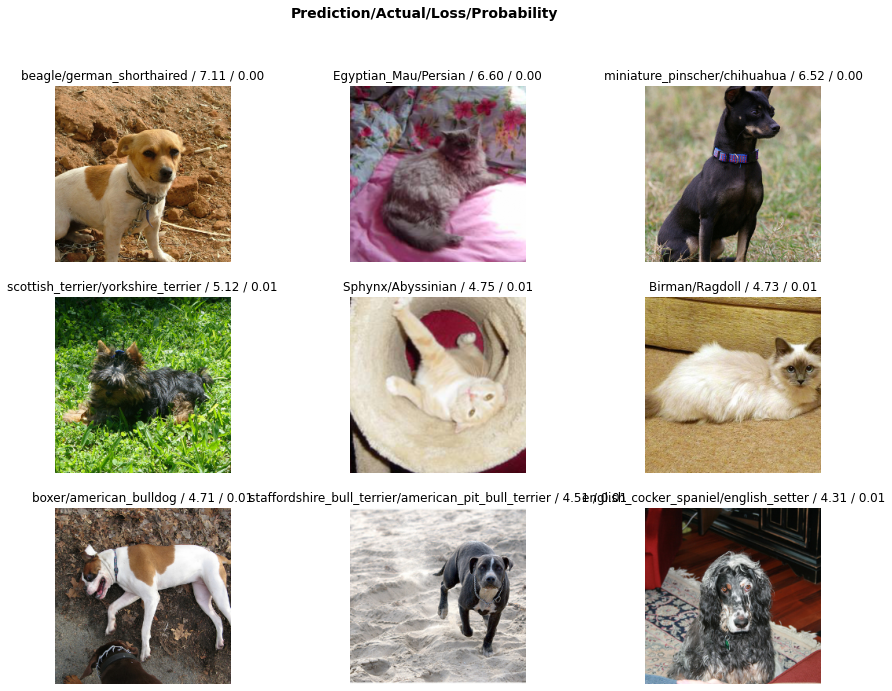

In [18]:
interp.plot_top_losses(9, figsize=(15,11))

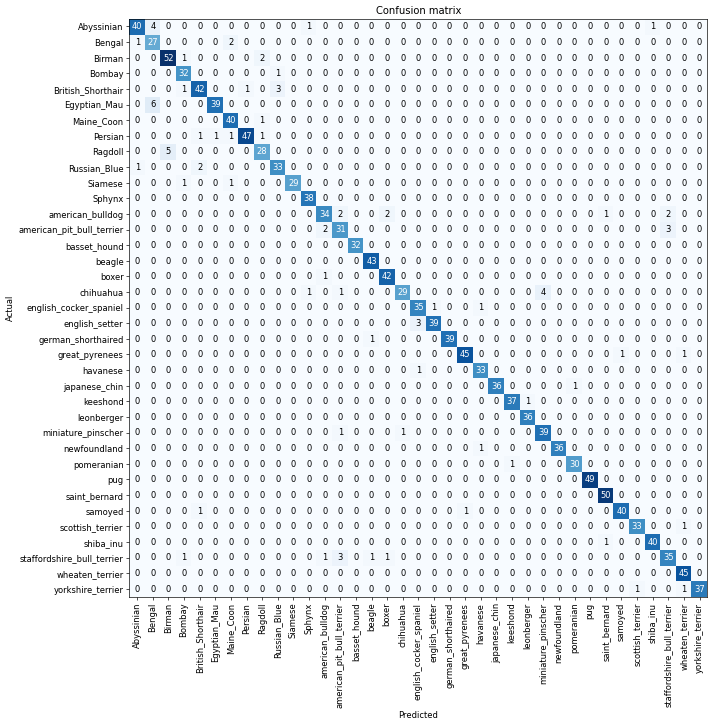

In [19]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [20]:
interp.most_confused(min_val=2)

[('Egyptian_Mau', 'Bengal', 6),
 ('Ragdoll', 'Birman', 5),
 ('Abyssinian', 'Bengal', 4),
 ('chihuahua', 'miniature_pinscher', 4),
 ('British_Shorthair', 'Russian_Blue', 3),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 3),
 ('english_setter', 'english_cocker_spaniel', 3),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 3),
 ('Bengal', 'Maine_Coon', 2),
 ('Birman', 'Ragdoll', 2),
 ('Russian_Blue', 'British_Shorthair', 2),
 ('american_bulldog', 'american_pit_bull_terrier', 2),
 ('american_bulldog', 'boxer', 2),
 ('american_bulldog', 'staffordshire_bull_terrier', 2),
 ('american_pit_bull_terrier', 'american_bulldog', 2)]

## Unfreezing our data, fine-tuning, and our learning rates

So, we have the model. Let's fine tune it. First, we need to load our model in.

In [21]:
learn.load('stage_1')

Learner(data=ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
saint_bernard,Persian,pug,german_shorthaired,miniature_pinscher
Path: /root/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Ragdoll,japanese_chin,newfoundland,havanese,shiba_inu
Path: /root/.fastai/data/oxford-iiit-pet/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), st

In [22]:
learn.unfreeze()

In [23]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.674914,0.361253,0.115020,01:28


In [24]:
learn.lr_find()  # lr_find: find learning rate

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


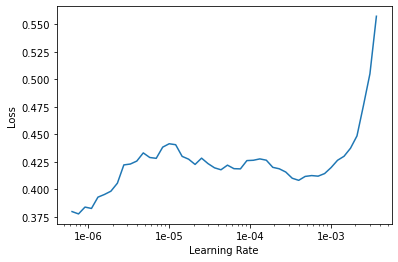

In [25]:
learn.recorder.plot()

In [26]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.369108,0.290829,0.094723,01:28
1,0.329198,0.275992,0.090663,01:28


In [27]:
learn.save('stage_2')

That's a pretty accurate model!

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [28]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=299).normalize(imagenet_stats)

In [29]:
learn = cnn_learner(data, models.resnet50, pretrained=True, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [30]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,time
0,0.733417,0.245360,0.087957,02:08
1,0.348572,0.178736,0.064276,02:06


In [31]:
learn.save('resnet50')

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


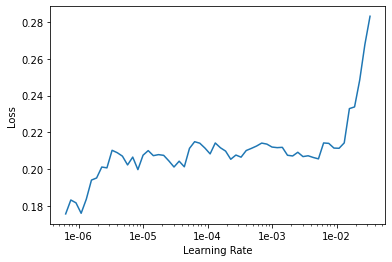

In [32]:
learn.lr_find()
learn.recorder.plot()

In [33]:
learn.load('resnet50')
learn.fit_one_cycle(3, max_lr=4e-4)

epoch,train_loss,valid_loss,error_rate,time
0,0.192188,0.165007,0.061570,02:05
1,0.181362,0.154951,0.053451,02:04
2,0.150402,0.154268,0.055480,02:08


In [34]:
learn.save('resnet50')